<h1><center>CSCI - 4146 - The Process of Data Science - Summer 2022</h1></center>
<h1><center>Assignment 1</h1></center>

<b>Justin Timmins</b>  
<B00>795685

### 1. Task 1<a id='top'></a>

Emphasis: Use this code: Bold: __string__ or **string** Italic: _string_ or *string* <a href='#1'>[1]</a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CONTINUOUS DATA QUALITY REPORT
              Count  Miss %   Card.     Min  1st Qrt.    Mean  Median  \
latitude    1046679    0.00  259382  -43.50    -28.77  -21.96  -19.92   
longitude   1046679    0.00  325532  113.13    126.80  135.25  133.14   
brightness  1046679    0.00    2050  300.00    317.90  332.88  328.70   
scan        1046679    0.00      39    1.00      1.10    1.66    1.30   
track       1046679    0.00      11    1.00      1.00    1.23    1.10   
acq_time    1046679    0.00     855    0.00    225.00  622.02  444.00   
confidence  1046679    0.00     101    0.00     56.00   71.06   74.00   
version     1046679    0.00       2    6.03      6.03    6.07    6.03   
bright_t31  1046679    0.00     972  265.70    295.90  303.23  303.00   
frp         1046679    0.00   13993  -29.90     14.60   70.50   28.60   
type        1046679    0.00       3  

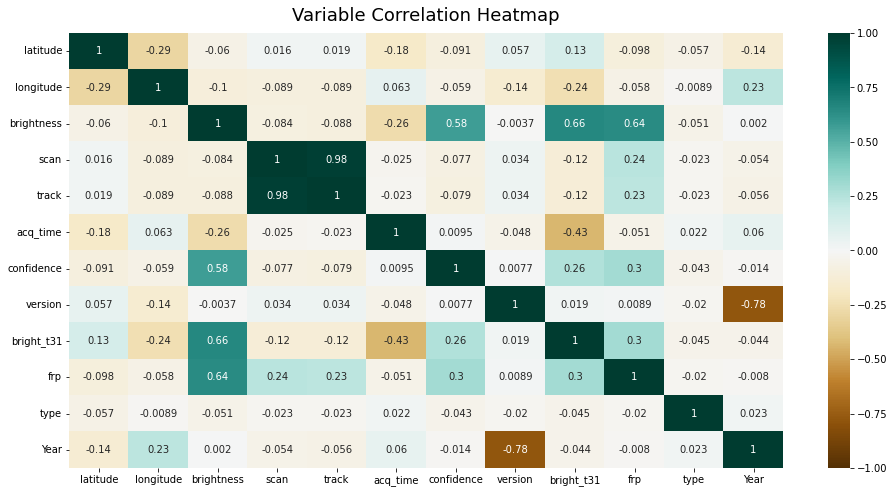

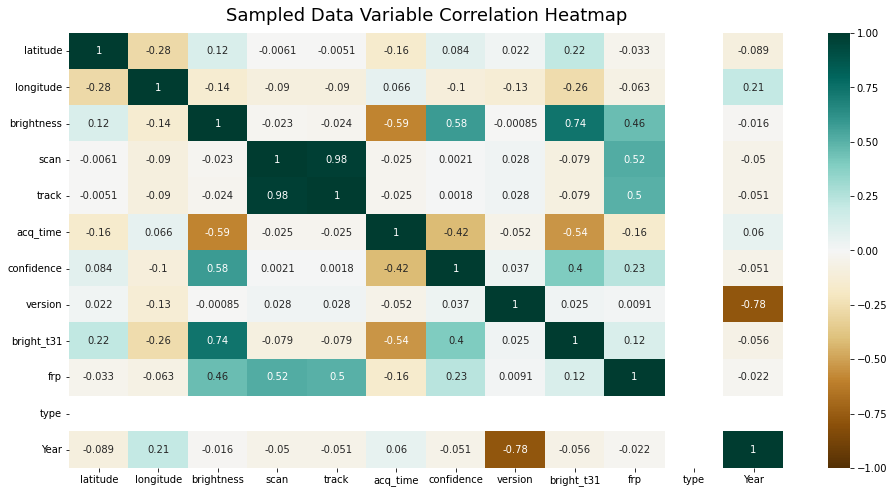

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import drive
drive.mount('/content/drive')#Mounting my google drive where I have csv files saved

#INITIALIZING PANDAS OPTIONS
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', '{:.2f}'.format)

#READING IN A DATA FROM 2017, 2018, 2019 AND 2020 THEN ADDING A "YEAR" COLOUMN TO EACH DATA FRAME THEN COMBINING ALL INTO ONE DATA FRAME
df2017 = pd.read_csv("/content/drive/My Drive/modis_2017_Australia.csv")
df2017['Year'] = 2017
df2018 = pd.read_csv("/content/drive/My Drive/modis_2018_Australia.csv")
df2018['Year'] = 2018
df2019 = pd.read_csv("/content/drive/My Drive/modis_2019_Australia.csv")
df2019['Year'] = 2019
df2020 = pd.read_csv("/content/drive/My Drive/modis_2020_Australia.csv")
df2020['Year'] = 2020
dataFrames = [df2017, df2018, df2019, df2020]
df = pd.concat(dataFrames)
#df = df.convert_dtypes()

#FUNCTION USED TO BUILD AND DISPLAY DATA REPORT FOR CONTINUOUS FEATURES(TAKEN FROM TUTORIAL 2)
def build_continuous_features_report(data_df):
    """Build tabular report for continuous features"""
    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }
    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]
    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())
    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)
    return report_df

#FUNCTION USED TO BUILD AND DISPLAY DATA REPORT FOR CATEGORICAL FEATURES(TAKEN FROM TUTORIAL 2)
def build_categorical_features_report(data_df):
    """Build tabular report for categorical features"""
    def _mode(df):
        return df.apply(lambda ft: ft.mode().to_list()).T
    def _mode_freq(df):
        return df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())
    def _second_mode(df):
        return df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list())
    def _second_mode_freq(df):
        return df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )
    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }
    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[cat_feat_names]
    report_df = pd.DataFrame(index=cat_feat_names, columns=stats.keys())
    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)
    return report_df

#PRINTING DATA QUALITY REPORTS
print("CONTINUOUS DATA QUALITY REPORT")
print(build_continuous_features_report(df),"\n")
print("CATEGORICAL DATA QUALITY REPORT")
print(build_categorical_features_report(df), "\n")

#DISPLAYING VARIABLE CORRELATION HEATMAP
plt.figure(figsize=(16,8))
varHeatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
varHeatmap.set_title("Variable Correlation Heatmap", fontdict={'fontsize':18}, pad=12)


#PREPROCCESSING DATA
df.drop('instrument', axis=1, inplace=False)#Removing the instrument coloumn as its cardinality is 1
df = df.loc[df["type"] == 0]#Removing all rows that indicate fire type is not a wildfire(ei. volcano)
df = df.loc[df["confidence"] < 90]#Removing all rows with a confidence above the 3rd quartile conf calculated as the dataset description indicates that high confidence is asscoaited with day or nighttime saturated pixels.
df = df.loc[((df["confidence"] < 56) & (df["daynight"] == 'N')) | (df["confidence"] > 56)]#Removing all rows with a confidence below the first quartile and are daytime fire pixels


dfSample = df.sample(n=150000)#Using random sampling to retreive a random 150,000 entries from our now preproccessed data frame


plt.figure(figsize=(16,8))
varHeatmap = sns.heatmap(dfSample.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
varHeatmap.set_title("Sampled Data Variable Correlation Heatmap", fontdict={'fontsize':18}, pad=12)
print("SAMPLED CONTINUOUS DATA QUALITY REPORT")
print(build_continuous_features_report(dfSample),"\n")
print("SAMPLED CATEGORICAL DATA QUALITY REPORT")
print(build_categorical_features_report(dfSample), "\n")

**MISSING HEATMAP IN PDF HERE**

**1.1.c**
  After generating data quality reports for the continuous and categorical features of the data set, as well as creating a heatmap of the correlation among variables I was able to a identify data quality issues and create the following data quality plan. 

  I first had to concatenate 4 csv files together to create the master data frame as each csv file corresponded to a particular year. Before concatenation I also added a 'year' coloumn to each data set so I can still differentiate data entries by year after concatenation. The archive had a 5th data set which was recorded in 2021 but after further investigation of the data set, I found that it was recording information in Romania but we are jsut looking at Australian wildfires in this assignment so I decided to leave that data set out. 

  Next, when looking at the categorical data quality report, I noticed that the 'instrument" feature's cardinality was 1 meaning that there is only 1 possibility for that feature so I was able to remove that feature entirely from the data set.

  Additionaly when looking at the datasets description, I noticed that there was multiple 'types' of fires/hotspots being recorded(presumed vegetation fire, active volcano, other static land source and offshore detection). Since our goal is to only track wildfires, I **must** remove all entries that arent of type "presumed vegetation wildfire" as I am not concerned with volcanos or other static fire sources.
  
  Finally, from looking at the data set description, I noticed that the 'confidence" feature, which is used to gauge the quality of an individual hotspot/firepixel seemed to be relatively unreliable in particular circumstances. A low confidence daytime pixel indicated areas of sunglint and lower relative temperature anomaly. While high confidence indicated pixels associated with day or nightime saturated pixels. On top of this low confidence nightime pixels only occur in a particular region which this data set does not involve so I only need to address low confidence daytime pixels as well as high confidence day and night time pixels. To acheive this I will delete all rows from the data frame with a confidence lower than the first quartile which are day time pixels. As well as delete all rows with a confidence above the third quartile.

After performing these data quality adsjustments, I should already have reduced the number of data entries significantly but will be using a random sample of 150,000 entries from the data frame i just reduced if it is still a very large number.


**1.3.a**
From the generated Categorical Data Quality Report, I found that the dates 2020-01-04 and 2019-12-30 were the most frequent in the data set. This is before I preproccessed the data to exclude non wildfire heat signatures and exlude false positive confidence entries. After performing a data quality report on my sampled data set, I found the dates 2020-01-04 and 2019-12-19 to be the most common and therefore are the dates in which bushfires present a high number of incidents.

**1.3.b**
Based on the previously conducted Data Quality Report, the attributes which I belive are useful to predict the confidence of an incident include brightness, bright_t31, and frp. This assumption is primarily based off the variable correlation heatmap. When looking at the confidence row, we can see what features are highly correlated with confidence to determine the most useful features. Brightness, bright_t31 and frp seem to be the highest correlated features and therefore most likely have the biggest impact on confidence. Additionally, I provide 2 Variable Correlation heat maps, one with the original data set and one with my preproccessed data set. The heat map with the preproccessed data set displays very similar results to the original, generally renforcing a positive or negative correlation. This is a good sign our preproccessing succefully got rid of the information useless to us as well as boosts my confidence that brightness, bright_t31 and frp ae the most useful features for predicting confidence.

### 1. Task 2

In [19]:
from pyrosm import OSM, get_data
import geopandas as gpd
import pandas as pd
#LOADING IN MAP OF AUSTRALIA
geography_type = "SSC"
shapes_url = f"https://www.censusdata.abs.gov.au/CensusOutput/copsubdatapacks.nsf/All%20docs%20by%20catNo/Boundaries_2016_{geography_type}/$File/2016_{geography_type}_shape.zip"
shapes_gpd = gpd.read_file(shapes_url)


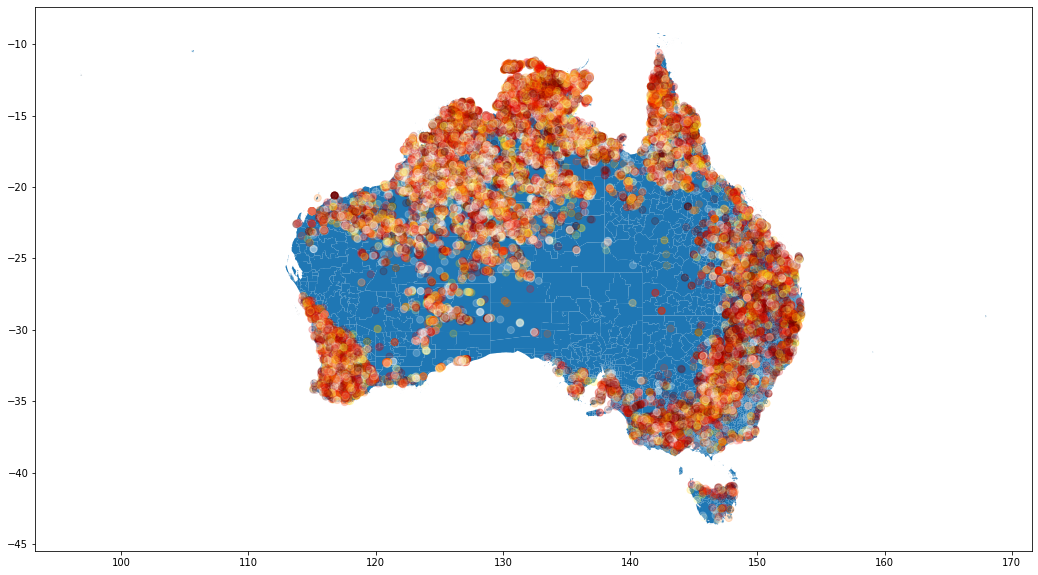

In [20]:
import shapely
dfSlice = dfSample = dfSample.loc[(dfSample["Year"] == 2017) & (dfSample["satellite"] == "Aqua")]#SLICING DATA SET BY: YEAR(2017) AND SATELLITE(AQUA)

#GENERATING GEODATA FRAME USING SLICED DATA
gdf = gpd.GeoDataFrame(dfSlice.drop(['longitude', 'latitude'], axis=1), crs='crs', geometry=[shapely.geometry.Point(xy) for xy in zip(dfSlice.longitude, dfSlice.latitude)])
gdf = gdf.to_crs("EPSG:4283")#AUSTRALIA CRS
#PLOTTING FIRE PIXELS ON AUSTRALIA 
ax=shapes_gpd.plot(figsize=(20,10))
gdf.plot(figsize=(20,10), markersize=50, column='frp', cmap="hot", vmin=2, vmax=50, alpha=0.2,ax=ax)



### 1. Task 3

FEATURE SELECTION

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:358: RuntimeWarning: invalid value encountered in true_divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


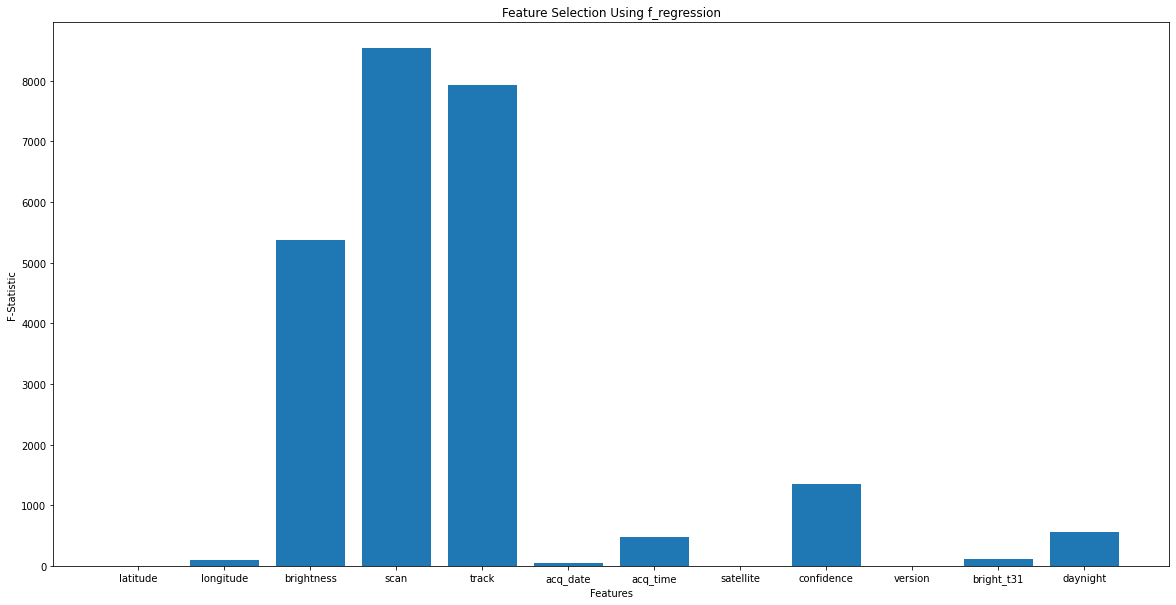

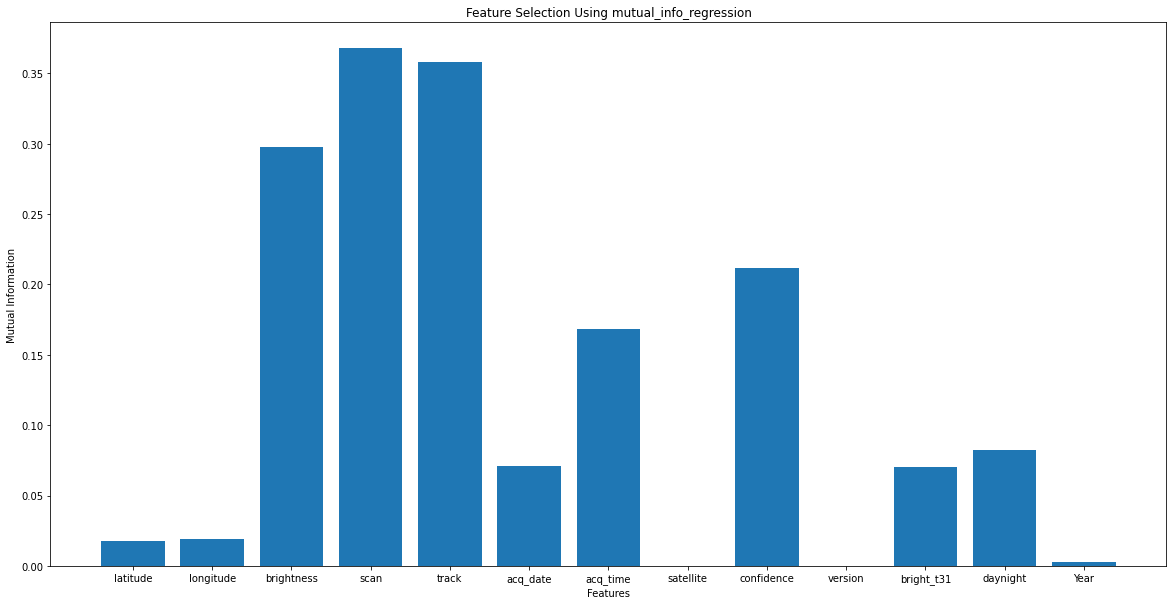

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
import numpy as np
#SPLITTING DATA SET INTO X AND Y AND DROPPING UNNNECCASARY COLUMNS
X = dfSample.drop('frp', axis=1)
X = X.drop('type', axis=1)
X = X.drop('instrument', axis=1)
y = dfSample['frp']

#GIVING ALL CATEGORICAL VALUES NUMRICAL TRANSLATIONS
X['satellite'] = pd.factorize(X['satellite'])[0]
X['acq_date'] = pd.factorize(X['acq_date'])[0]
X['daynight'] = pd.factorize(X['daynight'])[0]

#Performing K best feature selection using the f_regression metric
X_new = SelectKBest(f_regression, k=4).fit(X, y)
#PLOTIING RESULTS
fig = plt.figure(figsize=(20,10))
plt.bar(X.columns, X_new.scores_)
plt.xlabel("Features")
plt.ylabel("F-Statistic")
plt.title("Feature Selection Using f_regression")
plt.show()


#Performing K best feature selection using the mutual_info_regression metric
X_new2 = SelectKBest(mutual_info_regression, k=5).fit(X, y)
#PLOTTING RESULTS
fig = plt.figure(figsize=(20,10))
plt.bar(X.columns, X_new2.scores_)
plt.xlabel("Features")
plt.ylabel("Mutual Information")
plt.title("Feature Selection Using mutual_info_regression")
plt.show()




**3.2**
I decided to use Fire Radiative Power as my target feature.

My task at hand is to build a supervised regression model which is able to accurately predict the fire radiative power(frp) in an area based on the features available in the Australian Wildfdire Data set. My model is supervised as I already have access to thousands of records which include the label, in our case frp. I will be using a regression model as it makes the most sense for predicting continous a continuous target(ie. fire radiative power).

**3.3**
I decided to use the "SelectKBest" feature selection method as it uses univariate statistical tests to measure the dependancy between variables. In my case, I will be using 2 different dependancy measures in attempts to eliminate bias and find the most relevant features. I first used the f_regression scoring metric which measures the linear dependancy between each feature and the target feature. I was then able to graph each feature f-statistic which was calculated. Next I did the same thing using mutual_info_regression instead of f_regression. Mutual info regression measures dependancy between attributes based on entropy estimation from k nearest neighbours distances. With my 2 graphs plotted, I was able to compare results to narrow down my feature selection to 3 features; brightness, scan and track. These were clearly the only relevant features in the f_regression graph. The mutual info regression graph also presented acq_time and confidence to be relatively useful but their score was still half of whart brightness, scan and track displayed so I decided to omit them for the time being.

**3.4**
  I chose my evaluation metric to be the r2 score. This is due to the fact that I am trying to solve a regression problem. It is highly unlikely to make a model that can predict contiuous data perfectly so when dealing with regression it can be more useful to judge the skill of a model by how little error it can produce as oppose to how perfectly accurate it is(more than often your prediction wont be spot on). The r2 score essentialy measures the difference betweens samples from the data set and predictions made by the model. I chose the r2 score for my evaluation metric because it displays the skill of a regression model better than the standard accuracy score.


BASELINE MODEL

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
#TRIMMING DATA SET SO THAT ONLY RELEVANT FEATURES ARE INCLUDED
trimmedX = X.drop('latitude', axis=1)
trimmedX = trimmedX.drop('longitude', axis=1)
trimmedX = trimmedX.drop('acq_date', axis=1)
trimmedX = trimmedX.drop('acq_time', axis=1)
trimmedX = trimmedX.drop('satellite', axis=1)
trimmedX = trimmedX.drop('confidence', axis=1)
trimmedX = trimmedX.drop('version', axis=1)
trimmedX = trimmedX.drop('bright_t31', axis=1)
trimmedX = trimmedX.drop('daynight', axis=1)
trimmedX = trimmedX.drop('Year', axis=1)

y=y.astype('int')#converting target values to ints

linRegModel = LinearRegression().fit(trimmedX, y)#BUILDING MODEL


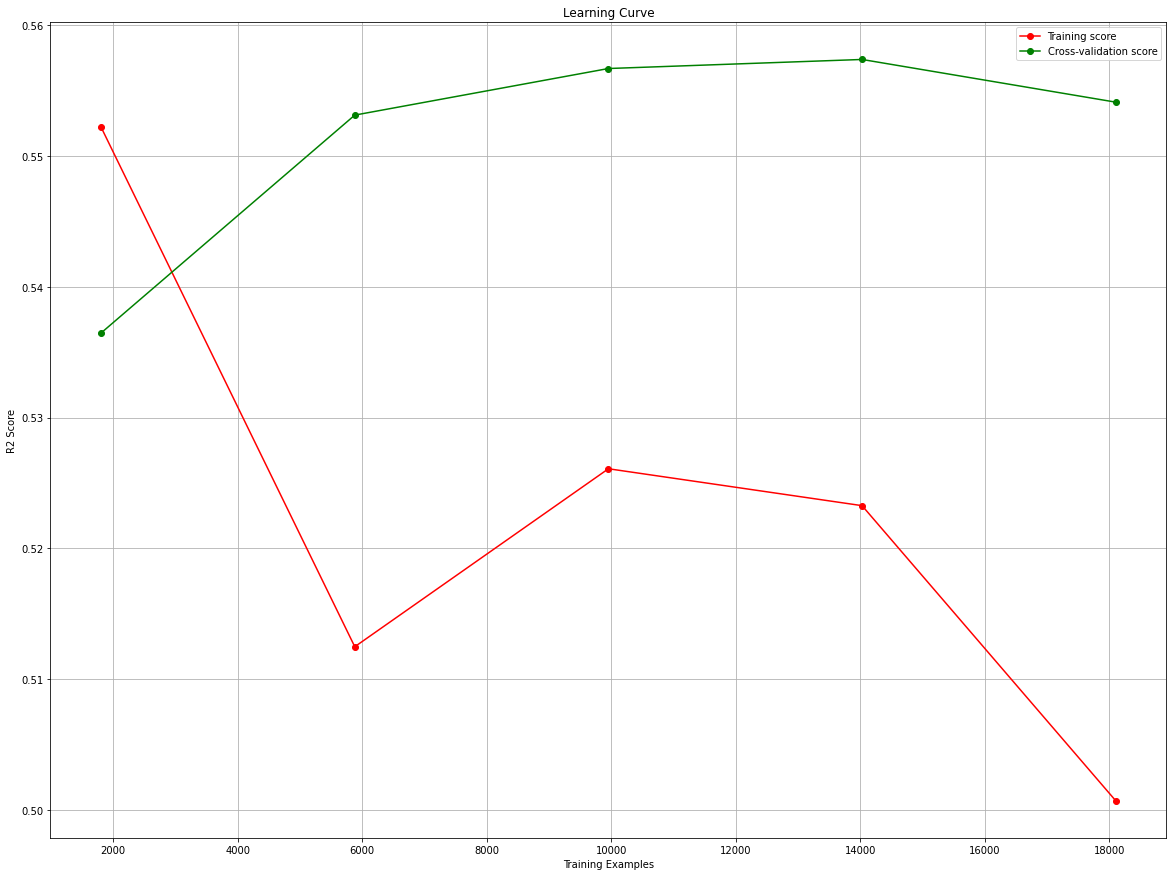

In [28]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

#PLOTTING LEARNING CURVE(taken from turorial 3)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(linRegModel, trimmedX, y, cv=5, return_times=True, shuffle=True,scoring='r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# Plot learning curve
fig, axes = plt.subplots(figsize=(20, 15))
axes.grid()
axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
axes.legend(loc="best")
plt.xlabel("Training Examples")
plt.ylabel("R2 Score")
plt.title("Learning Curve")
plt.show()

As seen from the learning curve above, the linear regression model seems to overfit the data when trained with around 5000 training examples or less. I am able to avoid overfitting by ensuring that I train my model using more than 5000 sample examples.
The results from my baseline model arent terrible but can certainly be imporved upon.

CANDIDATE FINAL MODEL

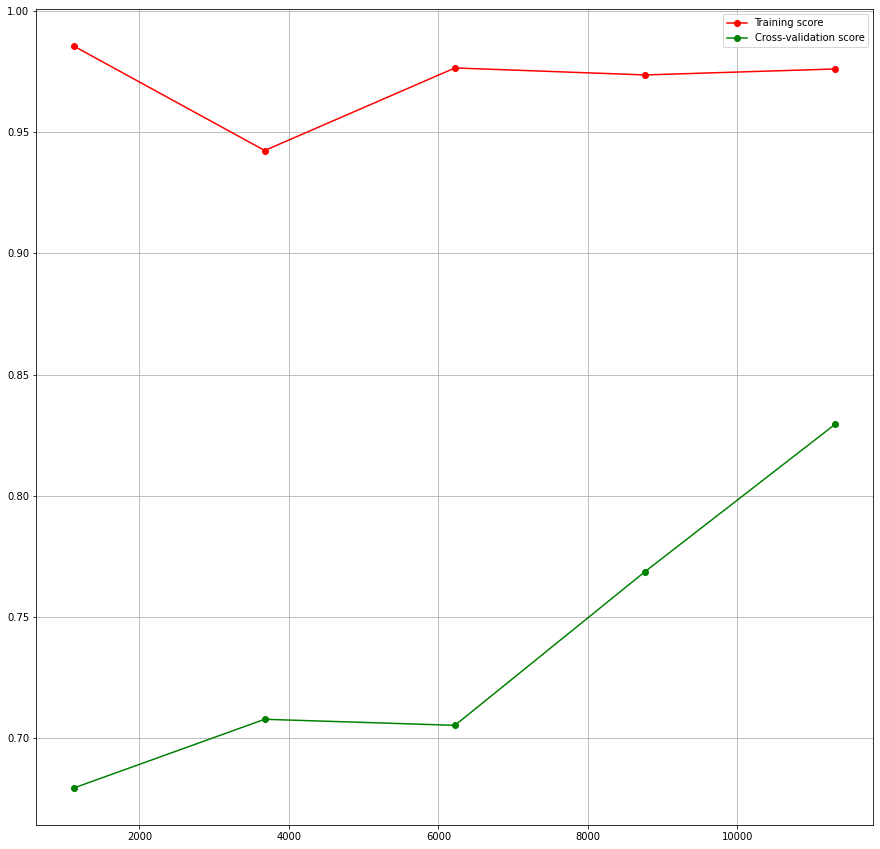

In [26]:
from sklearn.ensemble import RandomForestRegressor

rfrModel = RandomForestRegressor()

rfrModel = rfrModel.fit(trimmedX, y)

#PLOTTING LEARNING CURVE(taken from turorial 3)
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(rfrModel, trimmedX, y, cv=2, return_times=True, shuffle=True, scoring='r2')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
# Plot learning curve
fig, axes = plt.subplots(figsize=(15, 15))
axes.grid()
axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
axes.legend(loc="best")

As seen from the learning curve above, the Random Forest Regressor Model seems to overfit the training but at the cost of a significantly higher cross validation score than our previous model.
When working with such tedious data, it can be difficult for everything to always line, so a trade off of overfitting for overall higher scores is worth it. The random forest regressor signifdicantly out scores the linear regression model.

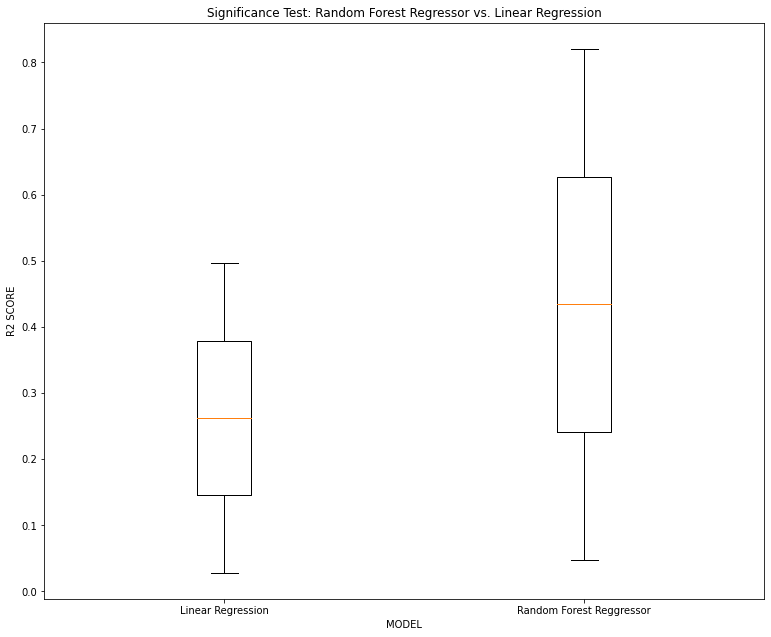

In [27]:
#FETCHING NEW X AND Y FROM THE NON-SAMPLED DATA FRAME SO WE HAVE SIGNIFICANTLY MORE DATA TO TEST OUR MODEL ON
fullX = df.drop('frp', axis=1)
fullX = fullX.drop('type', axis=1)
fullX = fullX.drop('instrument', axis=1)
fullX = fullX.drop('longitude', axis=1)
fullX = fullX.drop('latitude', axis=1)
fullX = fullX.drop('acq_date', axis=1)
fullX = fullX.drop('acq_time', axis=1)
fullX = fullX.drop('satellite', axis=1)
fullX = fullX.drop('confidence', axis=1)
fullX = fullX.drop('version', axis=1)
fullX = fullX.drop('bright_t31', axis=1)
fullX = fullX.drop('daynight', axis=1)
fullX = fullX.drop('Year', axis=1)

fullY = df['frp']

#SPLITTING TOTAL DATA SET INTO 8 EQUAL SIZE SETS
xSet1, xSet2, ySet1, ySet2 = train_test_split(fullX, fullY, train_size=0.5)
#4 Sets
xSet3, xSet4, ySet3, ySet4 = train_test_split(xSet1, ySet1, train_size=0.5)
xSet5, xSet6, ySet5, ySet6 = train_test_split(xSet2, ySet2, train_size=0.5)
#8 SETS
xSet7, xSet8, ySet7, ySet8 = train_test_split(xSet3, ySet3, train_size=0.5)
xSet9, xSet10, ySet9, ySet10 = train_test_split(xSet4, ySet4, train_size=0.5)
xSet11, xSet12, ySet11, ySet12 = train_test_split(xSet5, ySet5, train_size=0.5)
xSet13, xSet14, ySet13, ySet14 = train_test_split(xSet6, ySet6, train_size=0.5)

#CALCULATING SCORE FOR LINEAR REGRESSION MODEL ON 4 SEPERATE DATA SETS AND ADDING TO LIST
linRegScores = []
linReg_y_pred1 = linRegModel.predict(xSet7)
linRegScores.append(r2_score(ySet7, linReg_y_pred1))
linReg_y_pred2 = linRegModel.predict(xSet8)
linRegScores.append(r2_score(ySet8, linReg_y_pred2))
linReg_y_pred3 = linRegModel.predict(xSet9)
linRegScores.append(r2_score(ySet9, linReg_y_pred3))
linReg_y_pred4 = linRegModel.predict(xSet10)
linRegScores.append(r2_score(ySet10, linReg_y_pred4))
#CALCULATING SCORE FOR NEURAL NETWORK MODEL ON 4 SEPERATE DATA SETS AND ADDING TO LIST
neuralScores = []
neural_y_pred1 = rfrModel.predict(xSet11)
neuralScores.append(r2_score(ySet11, neural_y_pred1))
neural_y_pred2 = rfrModel.predict(xSet12)
neuralScores.append(r2_score(ySet12, neural_y_pred2))
neural_y_pred3 = rfrModel.predict(xSet13)
neuralScores.append(r2_score(ySet13, neural_y_pred3))
neural_y_pred4 = rfrModel.predict(xSet14)
neuralScores.append(r2_score(ySet14, neural_y_pred4))


#https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
fig = plt.figure(figsize=(10,8))
ax = fig.add_axes([0,0,1,1])
linRegData = [np.mean(linRegScores), np.std(linRegScores)]
neuralData = [np.mean(neuralScores), np.std(neuralScores)]
data = [linRegData, neuralData]
boxPlot = ax.boxplot(data)
plt.xticks([1,2], ['Linear Regression', 'Random Forest Reggressor'])
plt.title("Significance Test: Random Forest Regressor vs. Linear Regression")
plt.xlabel("MODEL")
plt.ylabel("R2 SCORE")
plt.show()
